# <center> Практика. Статистические тесты в контексте EDA

## Постановка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.
В процессе своего анализа необходимо:

1. Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
2. А также ответить на ключевые вопросы HR-агентства:
     * Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
     * Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
     * Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
     * Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

На каждый вопрос необходимо ответить с уровнем значимости $\alpha=0.05$.

Данные содержат следующие столбцы:
* work_year	-	Год, в котором была выплачена зарплата.
* experience_level	-	Опыт работы на этой должности в течение года со следующими возможными значениями:
    - EN — Entry-level/Junior;
    - MI — Mid-level/Intermediate;
    - SE — Senior-level/Expert;
    - EX — Executive-level/Director.•	
* employment_type	-	Тип трудоустройства для этой роли:
    - PT — неполный рабочий день;
    - FT — полный рабочий день;
    - CT — контракт;
    - FL — фриланс.
* job_title	-	Роль, в которой соискатель работал в течение года.
* salary	-	Общая выплаченная валовая сумма заработной платы.
* salary_currency	-	Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.
* salary_in_usd	-	Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).
* employee_residence	-	Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.
* remote_ratio	-	Общий объём работы, выполняемой удалённо. Возможные значения:
    - 0 — удалённой работы нет (менее 20 %);
    - 50 — частично удалённая работа;
    - 100 — полностью удалённая работа (более 80 %).
* company_location	-	Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
* company_size	-	Среднее количество людей, работавших в компании в течение года:
    - S — менее 50 сотрудников (небольшая компания);
    - M — от 50 до 250 сотрудников (средняя компания);
    - L — более 250 сотрудников (крупная компания).


Оригинальный датасет: [“Data Science Job Salaries” (kaggle.com)](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries)

## Загрузка данных

In [1]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np
import re

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

In [2]:
# загружаем датасет
data = pd.read_csv('data/ds_salaries.csv', index_col=[0])
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [3]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


## Описательный анализ данных

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 56.9+ KB


В датасете 607 записей (без пропущенных значений).

Проверим данные на наличие полных дубликатов:

In [5]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

# Удаляем дубликаты:
data = data.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(data.shape))

Количество дубликатов: 42
Размер таблицы после удаления дубликатов: (565, 11)


Посмотрим на краткую статистику по столбцам

In [6]:
data.describe(include='all')

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
count,565.000000,565,565,565,5.650000e+02,565,565.000000,565,565.000000,565,565
unique,NaN,4,4,50,NaN,17,NaN,57,NaN,50,3
top,NaN,SE,FT,Data Scientist,NaN,USD,NaN,US,NaN,US,M
freq,NaN,243,546,130,NaN,359,NaN,295,NaN,318,290
mean,2021.364602,NaN,NaN,NaN,3.381160e+05,NaN,110610.343363,NaN,69.911504,NaN,NaN
std,0.698138,NaN,NaN,NaN,1.599879e+06,NaN,72280.702792,NaN,40.900666,NaN,NaN
min,2020.000000,NaN,NaN,NaN,4.000000e+03,NaN,2859.000000,NaN,0.000000,NaN,NaN
25%,2021.000000,NaN,NaN,NaN,6.700000e+04,NaN,60757.000000,NaN,50.000000,NaN,NaN
50%,2021.000000,NaN,NaN,NaN,1.109250e+05,NaN,100000.000000,NaN,100.000000,NaN,NaN
75%,2022.000000,NaN,NaN,NaN,1.650000e+05,NaN,150000.000000,NaN,100.000000,NaN,NaN


### Распределение зарплаты в долларах США

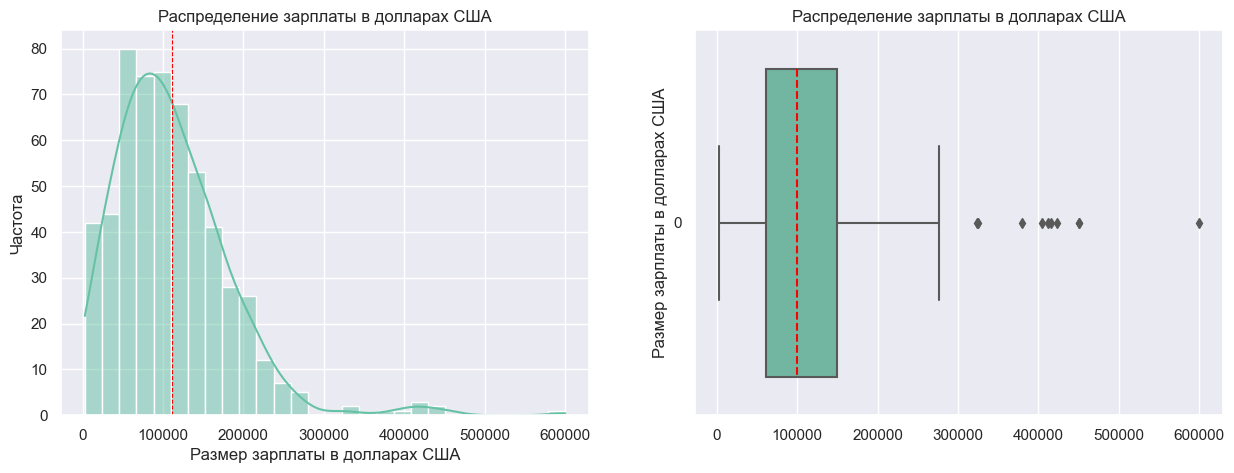

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Размер зарплаты в долларах США', ylabel='Частота')
axes[0].set_title('Распределение зарплаты в долларах США')
axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Размер зарплаты в долларах США')
axes[1].set_title('Распределение зарплаты в долларах США')

plt.show()

Распределение зарплаты в долларах США отлично от нормального, имеются выбросы.

### 1.1 Рассмотрим влияние числовых признаков с помощью корреляции

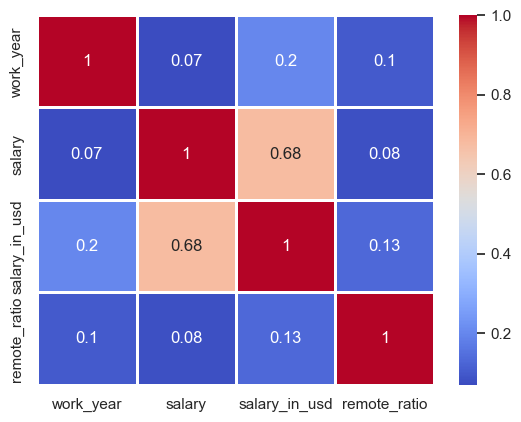

In [8]:
sns.heatmap(round(data.corr(method = 'kendall', numeric_only=True), 2), annot=True, linewidths=.9, cmap='coolwarm');

**Вывод**

Столбец 'salary_in_usd' является производным от 'salary' поэтому наблюдается средняя связь. Год выдачи зарплаты очень слабо положительно коррелирует с ЗП. Удаленность работы практически не влияет на размер ЗП

Cтолбцы 'salary' и 'salary_currency' можно удалить

In [9]:
data = data.drop(['salary', 'salary_currency'], axis=1)

### 1.2 Влияние категориальных признаков на ЗП

#### Влияние опыта работы на этой должности в течение года на ЗП

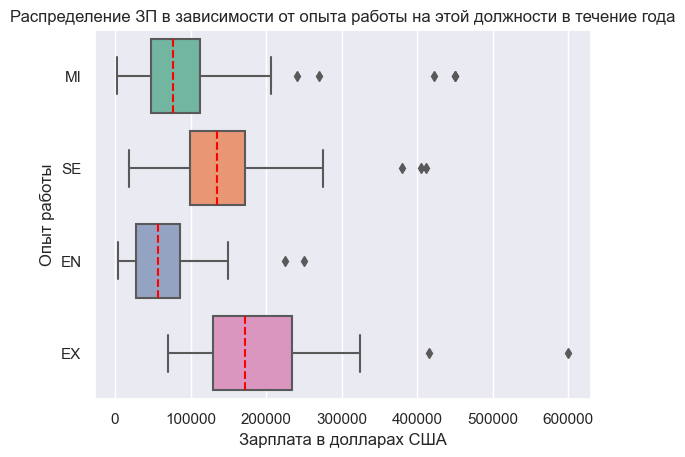

In [10]:
ax = sns.boxplot(data, x='salary_in_usd', y='experience_level', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Зарплата в долларах США', ylabel='Опыт работы')
plt.title('Распределение ЗП в зависимости от опыта работы на этой должности в течение года')
plt.show()

In [11]:
data_agg = data.groupby('experience_level')['salary_in_usd'].describe().round(2).sort_values('mean')
print('ЗП в зависимости от опыта работы')
data_agg

ЗП в зависимости от опыта работы


,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EN,88.0,61643.32,44395.54,4000.0,27505.00,56500.0,85425.75,250000.0
MI,208.0,87793.00,64118.97,2859.0,47163.75,76940.0,112075.00,450000.0
SE,243.0,138374.88,59955.97,18907.0,99531.50,135000.0,171881.00,412000.0
EX,26.0,199392.04,117071.26,69741.0,130006.50,171437.5,233750.00,600000.0


На первый взгляд распределения ЗП для разных должностей различны. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистическое тестирование.

#### Влияние типа трудоустройства на ЗП

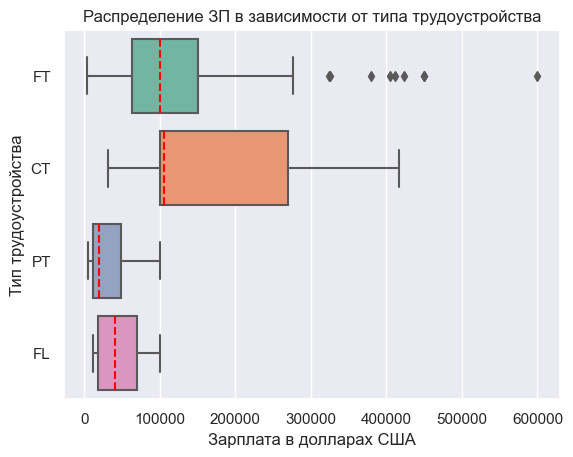

In [12]:
ax = sns.boxplot(data, x='salary_in_usd', y='employment_type', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Зарплата в долларах США', ylabel='Тип трудоустройства')
plt.title('Распределение ЗП в зависимости от типа трудоустройства')
plt.show()

In [13]:
data_agg = data.groupby('employment_type')['salary_in_usd'].describe().round(2).sort_values('mean')
print('ЗП в зависимости от типа трудоустройства')
data_agg

ЗП в зависимости от типа трудоустройства


,count,mean,std,min,25%,50%,75%,max
employment_type,,,,,,,,
PT,10.0,33070.50,31472.91,5409.0,12000.0,18817.5,48370.0,100000.0
FL,4.0,48000.00,40529.82,12000.0,18000.0,40000.0,70000.0,100000.0
FT,546.0,111811.84,70790.70,2859.0,62726.0,100000.0,150000.0,600000.0
CT,5.0,184575.00,156250.89,31875.0,100000.0,105000.0,270000.0,416000.0


На первый взгляд распределения ЗП для разных типов трудоустройств различны. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистическое тестирование.

#### Влияние ролей соискателя на ЗП

In [14]:
# Выберем 5 популярных ролей
popular_positions = list(data['job_title'].value_counts().head(5).index)
data_job = data[data['job_title'].isin(popular_positions)]

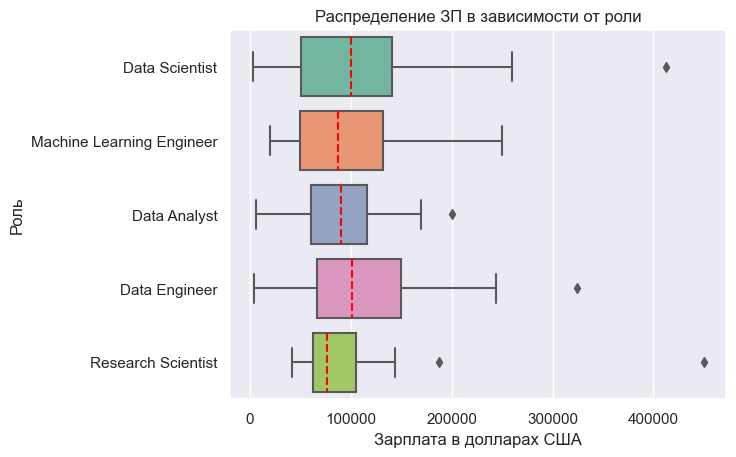

In [15]:
ax = sns.boxplot(data_job, x='salary_in_usd', y='job_title', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Зарплата в долларах США', ylabel='Роль')
plt.title('Распределение ЗП в зависимости от роли')
plt.show()

In [16]:
data_agg = data_job.groupby('job_title')['salary_in_usd'].describe().round(2).sort_values('mean')
print('ЗП в зависимости от роли')
data_agg

ЗП в зависимости от роли


,count,mean,std,min,25%,50%,75%,max
job_title,,,,,,,,
Data Analyst,82.0,90089.60,40686.26,6072.0,60325.00,90000.0,116112.5,200000.0
Machine Learning Engineer,39.0,101165.13,62518.56,20000.0,49173.00,87425.0,131500.0,250000.0
Data Scientist,130.0,103336.35,63967.56,2859.0,50330.25,100000.0,140400.0,412000.0
Research Scientist,16.0,109019.50,98542.76,42000.0,62176.00,76263.5,105000.0,450000.0
Data Engineer,121.0,109750.03,58203.68,4000.0,66022.00,100800.0,150000.0,324000.0


На первый взгляд распределения ЗП для разных ролей примерно сопоставимы. 

#### Влияние страны проживания на ЗП

In [17]:
# Выберем 5 самых распространенных стран 
popular_residence = list(data['employee_residence'].value_counts().head(5).index)
data_residence = data[data['employee_residence'].isin(popular_residence)]

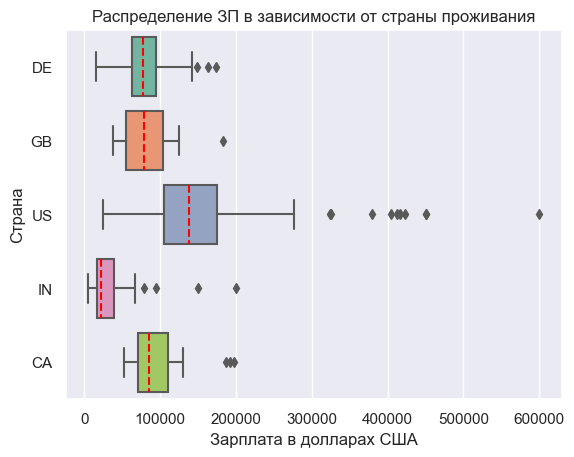

In [18]:
ax = sns.boxplot(data_residence, x='salary_in_usd', y='employee_residence', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Зарплата в долларах США', ylabel='Страна')
plt.title('Распределение ЗП в зависимости от страны проживания')
plt.show()

In [19]:
data_agg = data_residence.groupby('employee_residence')['salary_in_usd'].describe().round(2).sort_values('mean')
print('ЗП в от страны проживания')
data_agg

ЗП в от страны проживания


,count,mean,std,min,25%,50%,75%,max
employee_residence,,,,,,,,
IN,30.0,37322.33,43741.19,5409.0,16397.00,22124.0,38812.75,200000.0
GB,43.0,81470.07,30283.75,37300.0,55247.00,78526.0,103931.00,183228.0
DE,24.0,85336.67,40215.64,15966.0,62411.25,78015.0,94859.50,173762.0
CA,27.0,97191.63,40151.79,52000.0,71349.00,85000.0,110397.50,196979.0
US,295.0,150094.92,70918.56,25000.0,105200.00,138000.0,175550.00,600000.0


Распределения ЗП для разных стран проживания различны. 

#### Влияние страны работодателя на ЗП

In [20]:
# Выберем 5 самых распространенных стран 
popular_loc = list(data['company_location'].value_counts().head(5).index)
data_loc = data[data['company_location'].isin(popular_loc)]

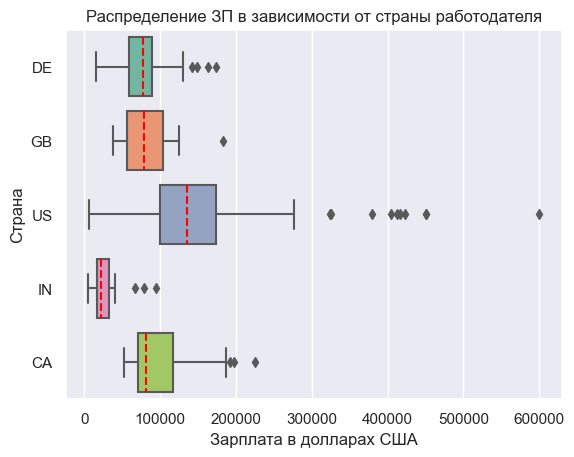

In [21]:
ax = sns.boxplot(data_loc, x='salary_in_usd', y='company_location', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Зарплата в долларах США', ylabel='Страна')
plt.title('Распределение ЗП в зависимости от страны работодателя')
plt.show()

In [22]:
data_agg = data_loc.groupby('company_location')['salary_in_usd'].describe().round(2).sort_values('mean')
print('ЗП в от страны работодателя')
data_agg

ЗП в от страны работодателя


,count,mean,std,min,25%,50%,75%,max
company_location,,,,,,,,
IN,24.0,28581.75,22697.67,5409.0,16735.0,22124.0,32163.25,94665.0
DE,27.0,81559.56,39903.44,15966.0,58669.0,76833.0,89694.00,173762.0
GB,46.0,81649.50,29846.70,37300.0,56915.5,78526.0,104316.50,183228.0
CA,28.0,100121.86,47080.71,52000.0,70518.0,81895.5,117374.75,225000.0
US,318.0,144292.99,72524.34,5679.0,100000.0,135000.0,173000.00,600000.0


Распределения ЗП для разных стран нахождения работодателя различны и сходны с распределением ЗП для разных стран проживания работника.

#### Влияние размера компании на ЗП

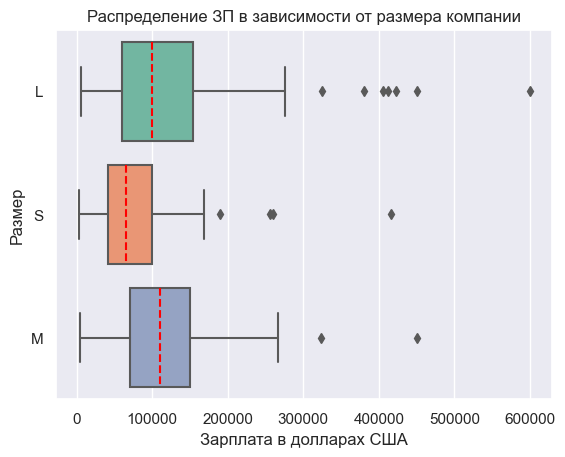

In [23]:
ax = sns.boxplot(data, x='salary_in_usd', y='company_size', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Зарплата в долларах США', ylabel='Размер')
plt.title('Распределение ЗП в зависимости от размера компании')
plt.show()

In [24]:
data_agg = data.groupby('company_size')['salary_in_usd'].describe().round(2).sort_values('mean')
print('ЗП в зависимости от размера компании')
data_agg

ЗП в зависимости от размера компании


,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
S,82.0,77872.10,63814.52,2859.0,41816.0,65511.0,100000.00,416000.0
M,290.0,114807.08,60779.04,4000.0,70821.5,109640.0,150213.75,450000.0
L,193.0,118213.88,86753.27,5882.0,60000.0,100000.0,153667.00,600000.0


На первый взгляд распределения ЗП для разных размеров компаний различны. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистическое тестирование.

## Статистический анализ данных



In [25]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
      

### Влияет ли опыт работы на размер ЗП?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер ЗП не отличается от опыта работы:

$$ H_0 : μ_1 = μ_2 = μ_3 = μ_4 $$

*Альтернативная гипотеза*: размер ЗП отличается от опыта работы:

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 \neq μ_4$$



**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [26]:
# значения ЗП
salary_en = data.loc[data['experience_level']=='EN', 'salary_in_usd']
salary_mi = data.loc[data['experience_level']=='MI', 'salary_in_usd']
salary_se = data.loc[data['experience_level']=='SE', 'salary_in_usd']
salary_ex = data.loc[data['experience_level']=='EX', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для Junior:')
result = stats.shapiro(salary_en)
decision_normality(result[1])

print('Для Intermediate:')
result = stats.shapiro(salary_mi)
decision_normality(result[1])

print('Для Expert:')
result = stats.shapiro(salary_se)
decision_normality(result[1])

print('Для Director:')
result = stats.shapiro(salary_ex)
decision_normality(result[1])


Для Junior:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для Intermediate:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для Expert:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для Director:
p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «ЗП»? — Количественный.
* Сколько сравниваемых групп? — Четыре.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий КРАСКЕЛА — УОЛЛИСА.

**Проведём тест**

In [27]:
# проводим тест
_, p = stats.kruskal(salary_en, salary_mi, salary_se, salary_ex)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Опыт работы влияет на размер ЗП.

### Влияет ли тип трудоустройства на размер ЗП?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер ЗП не отличается от типа трудоустройства:

$$ H_0 : μ_1 = μ_2 = μ_3 = μ_4 $$

*Альтернативная гипотеза*: размер ЗП отличается от типа трудоустройства:

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 \neq μ_4$$



**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [28]:
# значения ЗП
salary_pt = data.loc[data['employment_type']=='PT', 'salary_in_usd']
salary_ft = data.loc[data['employment_type']=='FT', 'salary_in_usd']
salary_ct = data.loc[data['employment_type']=='CT', 'salary_in_usd']
salary_fl = data.loc[data['employment_type']=='FL', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для неполный рабочий день:')
result = stats.shapiro(salary_pt)
decision_normality(result[1])

print('Для полный рабочий день:')
result = stats.shapiro(salary_ft)
decision_normality(result[1])

print('Для контракт:')
result = stats.shapiro(salary_ct)
decision_normality(result[1])

print('Для фриланс:')
result = stats.shapiro(salary_fl)
decision_normality(result[1])


Для неполный рабочий день:
p-value = 0.023
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для полный рабочий день:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для контракт:
p-value = 0.406
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для фриланс:
p-value = 0.507
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «ЗП»? — Количественный.
* Сколько сравниваемых групп? — Четыре.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет(часть имеет не нормальное распределение). 

Для проверки нашей гипотезы можно использовать критерий КРАСКЕЛА — УОЛЛИСА.

**Проведём тест**

In [29]:
# проводим тест
_, p = stats.kruskal(salary_pt, salary_ft, salary_ct, salary_fl)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

тип трудоустройства влияет на размер ЗП.

### Влияет ли размер компании на ЗП?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: ЗП не отличается в разных по размеру компаниях:

$$ H_0 : μ_1 = μ_2 = μ_3 = μ_4 $$

*Альтернативная гипотеза*: ЗП отличается в разных по размеру компаниях:

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 \neq μ_4 $$



**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [30]:
# значения ЗП
salary_s = data.loc[data['company_size']=='S', 'salary_in_usd']
salary_m = data.loc[data['company_size']=='M', 'salary_in_usd']
salary_l = data.loc[data['company_size']=='L', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для небольшая компания:')
result = stats.shapiro(salary_s)
decision_normality(result[1])

print('Для средняя компания:')
result = stats.shapiro(salary_m)
decision_normality(result[1])

print('Для крупная компания:')
result = stats.shapiro(salary_l)
decision_normality(result[1])


Для небольшая компания:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для средняя компания:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для крупная компания:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «ЗП»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий КРАСКЕЛА — УОЛЛИСА.

**Проведём тест**

In [31]:
# проводим тест
_, p = stats.kruskal(salary_s, salary_m, salary_l)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Размер компании влияет на ЗП. Проведем дальнейшее исследование для проверки характера различий.

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер ЗП в мелкой компании ($μ_1$) статистически больше либо равен размеру ЗП в более крупной компании ($μ_2$).

$$ H_0 : μ_1 >= μ_2 $$

*Альтернативная гипотеза* ($H_1$): размер ЗП в мелкой компании ($μ_1$) статистически меньше, чем размер ЗП в более крупной компании ($μ_2$).

$$ H_1 : μ_1 < μ_2 $$

In [32]:
# проводим тест 
print('Значение р для компаний S и M')
_, p = stats.mannwhitneyu(salary_s, salary_m, alternative='less')
decision_hypothesis(p)

Значение р для компаний S и M
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


In [33]:
# проводим тест 
print('Значение р для компаний M и L')
_, p = stats.mannwhitneyu(salary_m, salary_l, alternative='less')
decision_hypothesis(p)

Значение р для компаний M и L
p-value = 0.842
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Размер ЗП зависит от размера компании: в небольшой компании уровень ЗП меньше, чем в более крупных. Уровень ЗП в средних и крупных компаниях не отличается.

### Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

In [34]:
# Отберем все должности data scientist
''' 
Пример конструкции сложного условия
data_ds = data[data['job_title'].str.contains('Scientist') & 
     (data['job_title'].str.contains('Research') == False) &
     (data['job_title'].str.contains('AI') == False) &
     (data['job_title'].str.contains('Machine') == False)
]
'''
# Аналогичный результат
data_ds = data[data['job_title'].str.contains('Data Scientist', flags = re.IGNORECASE)]

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [35]:
# значения ЗП
salary_20 = data_ds.loc[data_ds['work_year']==2020, 'salary_in_usd']
salary_21 = data_ds.loc[data_ds['work_year']==2021, 'salary_in_usd']
salary_22 = data_ds.loc[data_ds['work_year']==2022, 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для 2020:')
result = stats.shapiro(salary_20)
decision_normality(result[1])

print('Для 2021:')
result = stats.shapiro(salary_21)
decision_normality(result[1])

print('Для 2022:')
result = stats.shapiro(salary_22)
decision_normality(result[1])


Для 2020:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для 2021:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для 2022:
p-value = 0.023
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального



**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер ЗП в прошлом году ($μ_1$) статистически больше либо равен текущему размеру ЗП ($μ_2$).

$$ H_0 : μ_1 >= μ_2 $$

*Альтернативная гипотеза* ($H_1$): размер ЗП в прошлом году ($μ_1$) статистически меньше, чем текущий размер ЗП ($μ_2$).

$$ H_1 : μ_1 < μ_2 $$

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «ЗП»? — Количественный.
* Сколько сравниваемых групп? — Два.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий U-КРИТЕРИЙ МАННА — УИТНИ.

**Проведём тест**

In [36]:
# проводим тест для 2020, 2021 года
_, p = stats.mannwhitneyu(salary_20, salary_21, alternative='less')
decision_hypothesis(p)

p-value = 0.670
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


In [37]:
# проводим тест 2021, 2022 года
_, p = stats.mannwhitneyu(salary_21, salary_22, alternative='less')
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


In [38]:
# проводим тест 2020, 2022 года
_, p = stats.mannwhitneyu(salary_20, salary_22, alternative='less')
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Уровень ЗП в 2022 больше, чем в 2021 и в 2020. Но уровень ЗП в 2021, меньше чем в 2020. Нельзя сделать однозначный вывод о ежегодном росте ЗП Data Scientist.

### Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [39]:
# значения ЗП
salary_22_ds = data.loc[(data['work_year']==2020) & (data['job_title']=='Data Scientist'), 'salary_in_usd']
salary_22_de = data.loc[(data['work_year']==2020) & (data['job_title']=='Data Engineer'), 'salary_in_usd']


# проводим тест Шапиро-Уилка
print('Для Data Scientist:')
result = stats.shapiro(salary_22_ds)
decision_normality(result[1])

print('Для Data Engineer:')
result = stats.shapiro(salary_22_de)
decision_normality(result[1])


Для Data Scientist:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для Data Engineer:
p-value = 0.341
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным



**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: ЗП 2022 года не отличается в профессиях Data Scientist и Data Engineer:

$$ H_0 : μ_1 = μ_2 $$

*Альтернативная гипотеза*: ЗП 2022 года отличается в профессиях Data Scientist и Data Engineer:

$$ H_1 : μ_1 \neq μ_2 $$

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «ЗП»? — Количественный.
* Сколько сравниваемых групп? — Два.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий U-КРИТЕРИЙ МАННА — УИТНИ.

**Проведём тест**

In [40]:
# проводим тест для 2020, 2021 года
_, p = stats.mannwhitneyu(salary_22_ds, salary_22_de)
decision_hypothesis(p)

p-value = 0.427
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Уровень ЗП в 2022 году в профессиях Data Scientist и Data Engineer не отличается.

### Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

In [41]:
data_mod = data[(data['job_title']=='Data Engineer') | (data['job_title']=='Data Scientist')]

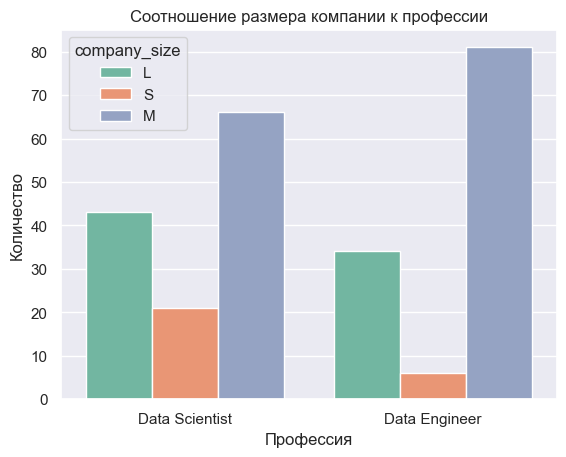

In [42]:
ax = sns.countplot(data=data_mod, x=data_mod['job_title'], hue='company_size')
ax.set(xlabel='Профессия', ylabel='Количество')
plt.title('Соотношение размера компании к профессии')
plt.show()


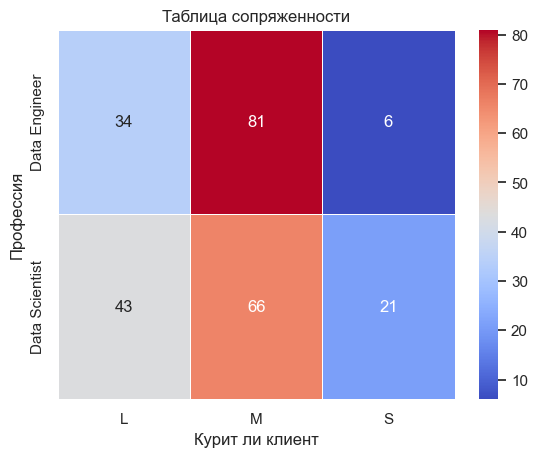

In [43]:
cross_tab = pd.crosstab(index=data_mod['job_title'], columns=data_mod['company_size'])
ax = sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm")
ax.set(xlabel='Курит ли клиент', ylabel='Профессия')
plt.title('Таблица сопряженности')
plt.show()


**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: между наличием должностей Data Scientist и Data Engineer и размером компании  нет взаимосвязи (признаки независимы).

*Альтернативная гипотеза*: между наличием должностей Data Scientist и Data Engineer и размером компании есть взаимосвязь (признаки зависимы).

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака профессия? — Категориальный.
* Сколько сравниваемых групп? — Две.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [44]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_tab)
decision_hypothesis(p)

p-value = 0.005
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Существует статистически значимая взаимосвязь между наличием должностей Data Scientist и Data Engineer и размером компании

## Итоговые результаты исследования
*   На уровень ЗП влияют следующие признаки: опыт работы, тип трудоустройства, размер компании, страна нахождения работодателя, страна проживания работника

*   Нельзя сделать однозначный вывод о ежегодном росте ЗП Data Scientist. Наблюдается рост ЗП в 2022 по сравнению с 2020 и 2021 годом

*   Уровень ЗП в 2022 году в профессиях Data Scientist и Data Engineer не отличается.

*   Размер ЗП зависит от размера компании: в небольшой компании уровень ЗП меньше, чем в более крупных. Уровень ЗП в средних и крупных компаниях не отличается.

*   Существует  взаимосвязь между наличием должностей Data Scientist и Data Engineer и размером компании.